In [1]:
using Random, Statistics, PyPlot, Polynomials

In [2]:
using JLD # to save to file

In [3]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

function NearestNeighbors(lat::SquareLattice, ind::Int64,direction::Int64)
    #directions 1->x 2->y
    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,2)
    
    if(direction==1)
        xp = mod(r.x, lat.Nx)+1
        xm = mod(r.x-2, lat.Nx)+1 
    elseif(direction==2)
        xp = mod(r.y, lat.Ny)+1
        xm = mod(r.y-2, lat.Ny)+1
    end
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end


NearestNeighbors (generic function with 2 methods)

In [6]:
data = load("./tmp/auto_sweeps_100000_36.jld")

Dict{String,Any} with 7 entries:
  "configs_vec" => [5.66949 5.72385 … 5.88927 5.66185; 1.13101 5.93282 … 1.3548…
  "N"           => 36
  "Ts"          => [0.1, 0.4, 0.5, 0.6, 0.9, 0.95, 1.0, 1.1, 1.15, 1.2, 1.3, 1.…
  "Ens"         => [-40.0235 22.3224 … 18.9903 -15.3723; -92.4357 17.7938 … 17.…
  "mys"         => [0.00316826 -0.0241369 … 0.0216544 0.0160146; -0.00332927 -0…
  "mxs"         => [-0.00618714 0.0166878 … 0.0367079 -0.0202988; -0.0425292 0.…
  "Ns"          => 100000

In [7]:
function CalculateError(m, Neq, Nsw)
    err = Float64[]
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than number of sweeps after equilibration
    ml = m[end-Nsw2+1:end]
    min_size = 2^5
    while length(ml) > min_size
        push!(err, std(ml)/sqrt(length(ml)-1))
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1,stop=div(length(ml),2)) )
    end
    return err
end



CalculateError (generic function with 1 method)

In [8]:
fig = figure(figsize=(10,10))
for (i,T) in enumerate(Ts)
    ax = fig.add_subplot(ceil(Int,length(Ts)/3),3,i)
    ax.set_title("T: $T")
    ax.plot(data["Ens"][:,i])
    xscale("log")
end
show()

LoadError: [91mUndefVarError: Ts not defined[39m

In [9]:
mxs = data["mxs"]
Ns = data["Ns"]
Neq_s = [50, 100, 100, 100,500,1000,1000,1000,1000,1000,1000,1000]
aut_cor_times = []
figure(figsize=(10,10))
for (i,T) in enumerate(Ts)
    err = CalculateError(mxs[:,i], Neq_s[i], Ns)
    plot(2 .^ range(0, length=length(err)), err, "--o",label="$T")
    auto_cor_time = round(((err[end]/err[1])^2-1)/2)
    println("Autocorrelation time for $T : ", auto_cor_time )
    append!(aut_cor_times,auto_cor_time)
end

ylabel("Error")
xlabel("Bin size")
xscale("log")
legend()

show()

LoadError: [91mUndefVarError: Ts not defined[39m

In [10]:
plot(Ts,aut_cor_times,"-o")
ylabel("auto correlation time")
xlabel("Temperature")
yscale("log")
show()

LoadError: [91mUndefVarError: Ts not defined[39m

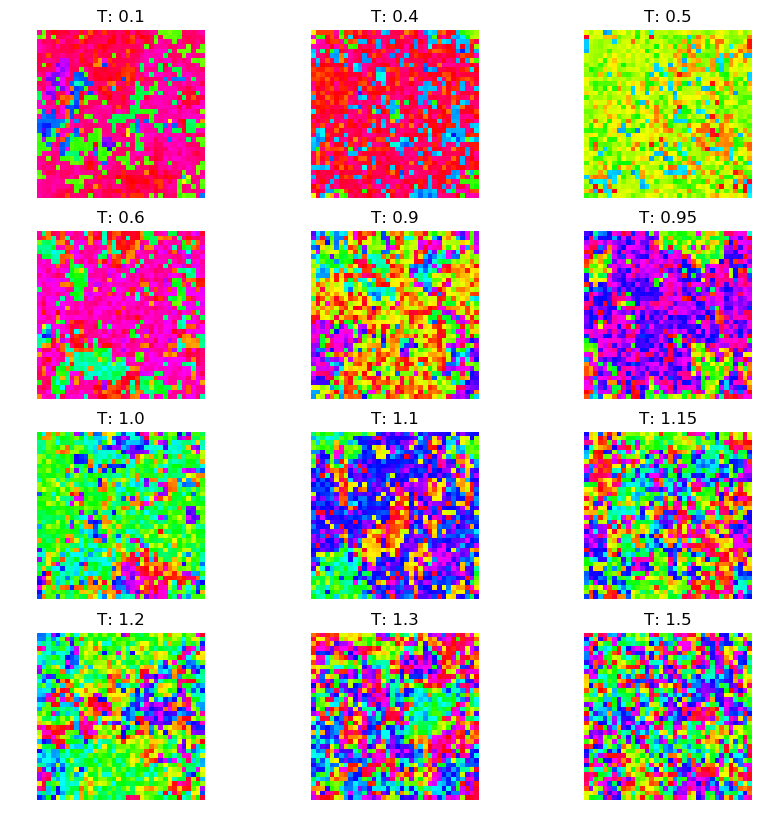

In [11]:
configs_vec = data["configs_vec"]
Ts = data["Ts"]
N = data["N"]
fig = figure(figsize=(10,10))

for (i,T) in enumerate(Ts)
    ax = fig.add_subplot(ceil(Int,length(Ts)/3),3,i)
    ax.imshow((reshape(configs_vec[i,:],(N,N))),cmap="hsv",origin="lower")
    ax.set_title("T: $T")
    ax.axis("off")
end
show()

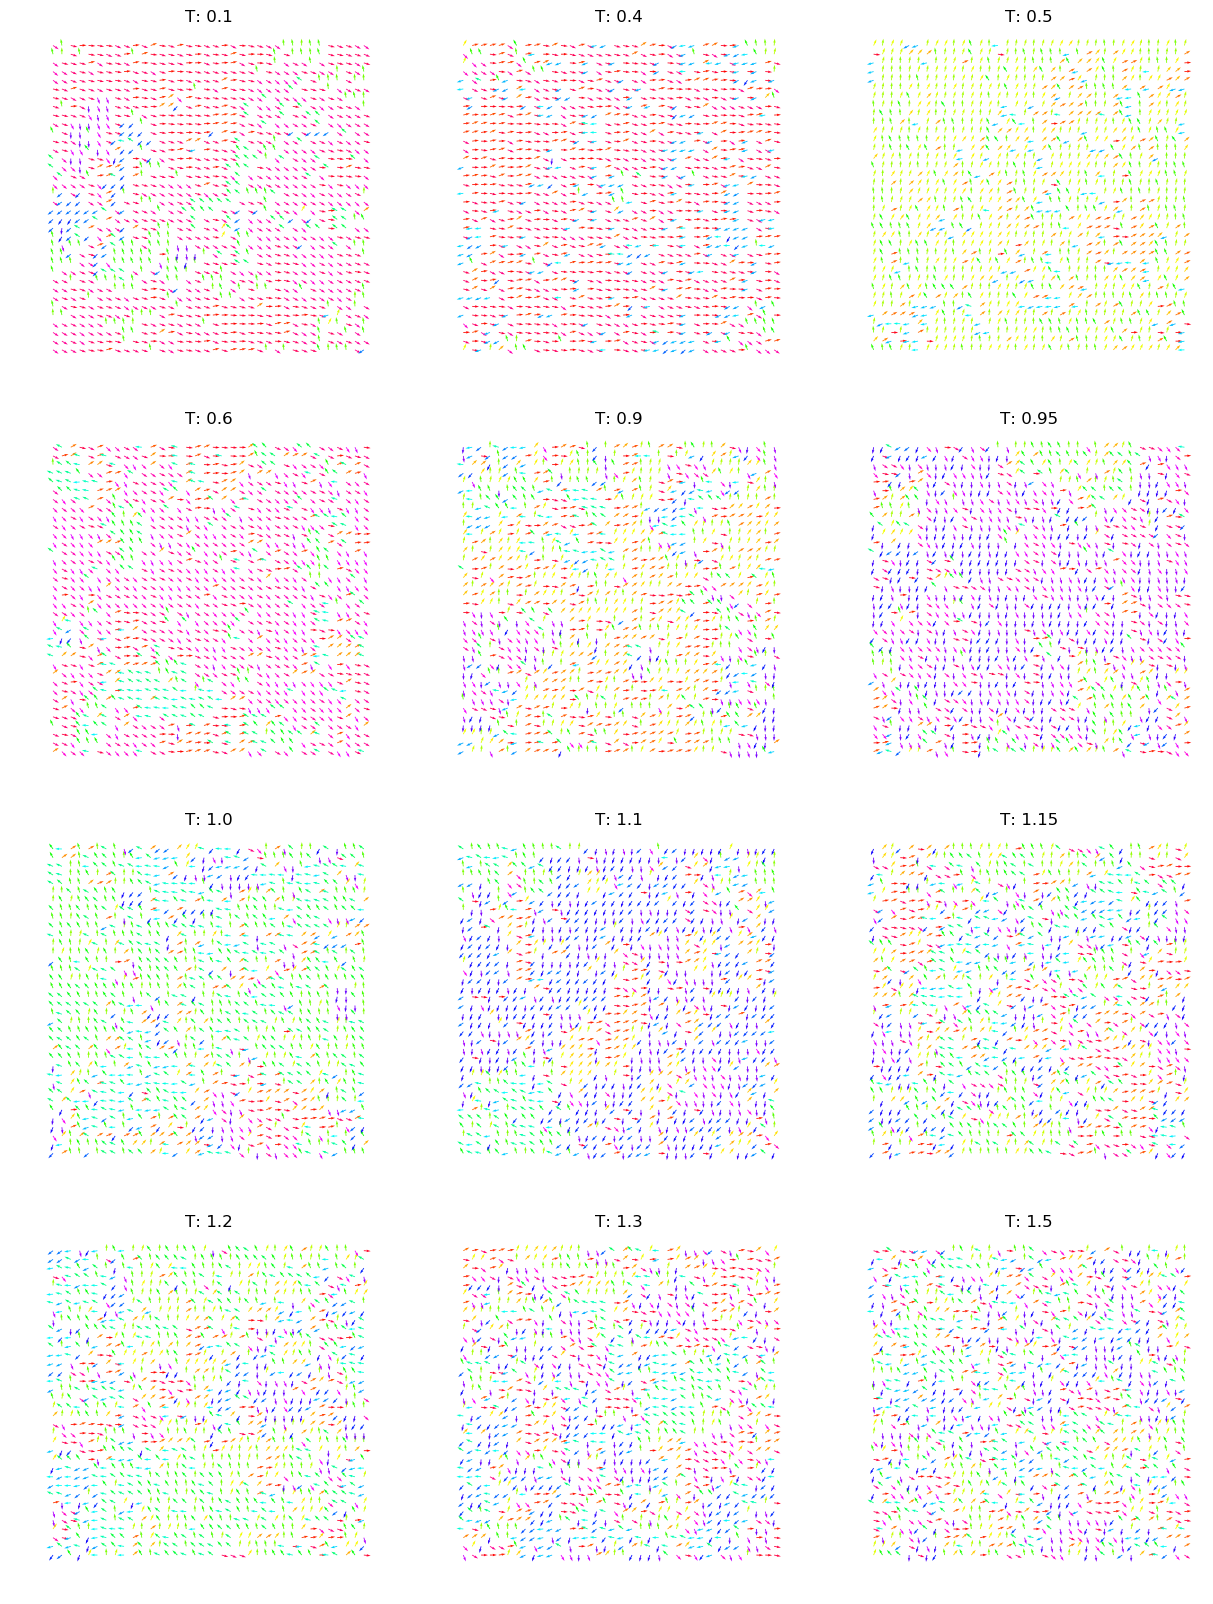

In [12]:
configs_vec = data["configs_vec"]
Ts = data["Ts"]
N = data["N"]
X = range(1,N, step=1);
Y = range(1, N, step=1);
fig = figure(figsize=(15,20))

for (i,T) in enumerate(Ts)
    ax = fig.add_subplot(ceil(Int,length(Ts)/3),3,i)
    conf = reshape(configs_vec[i,:],(N,N))
    U = map(x->cos(x),conf)
    V = map(x->sin(x),conf)
    ax.quiver(X,Y,U,V,conf,cmap="hsv",scale=50)
    ax.set_title("T: $T")
    ax.axis("off")
end
show()

In [13]:
function spin_spin_coorelation(configuration)
    configuration = reshape(configuration,(N,N))
    coorelations = zeros(Float64,N)
    for i in range(1,length=N)
        for j in range(1,length=N)
            coorelations[i] += cos(configuration[1,j]-configuration[i,j])
        end
        coorelations[i] = coorelations[i]/N
    end
    return coorelations
end

spin_spin_coorelation (generic function with 1 method)

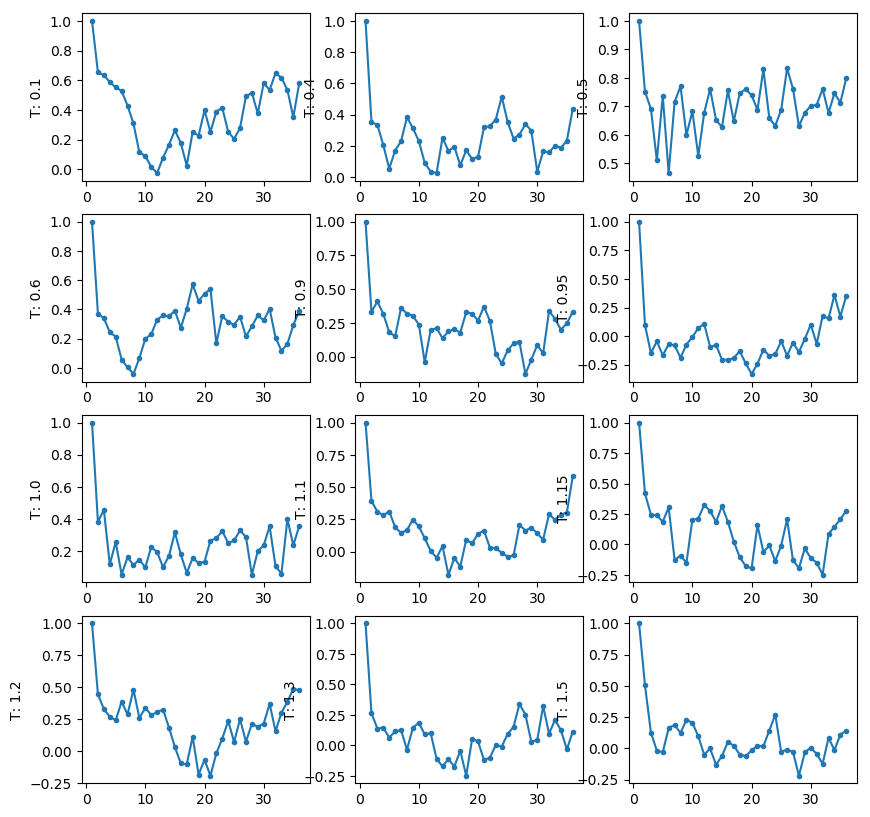

In [16]:
fig = figure(figsize=(10,10))

for (i,T) in enumerate(Ts)
    ax = fig.add_subplot(ceil(Int,length(Ts)/3),3,i)
    co = spin_spin_coorelation(configs_vec[i,:])
    ax.plot(range(1,length=N),co,".-",label="$T")
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_ylabel("T: $T")
end

show()

In [26]:
function Ia_squared(configuration,a::Int64,lat::SquareLattice)
    Ia_sq = 0
    for i in range(1,length=length(lat))
            nn = NearestNeighbors(lat,i,a)
        Ia_sq += sum(sin(-configuration[nn] .+configuration[j]))
    end
    
end


function calculate_ρs(configuration,lat::SquareLattice)
    
end

calculate_ρs (generic function with 1 method)